# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV928"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv928')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv928/lv928-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 12:31:41,167 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
2038,DMAP_ERY3,928,0.812153,3.225767e-27,1.159663e-24
2039,DMAP_ERY4,928,0.784254,1.269672e-19,2.489711e-17


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP035312, SRP034711, SRP015138, SRP036133, SRP056295, SRP061689, SRP046233, SRP050333, SRP005281, SRP063493, SRP036843, SRP063477, SRP063834, SRP014620, SRP066151, SRP050260, SRP018028, SRP048759, SRP044056, SRP047323, SRP055513, SRP003227, SRP041751, SRP062023, SRP052781, SRP050493, SRP055569, SRP011185, SRP052874, SRP047126, SRP062025, SRP009615, SRP050272, SRP017138, SRP018403, SRP055916, SRP050146, SRP051675, SRP041988, SRP015439, SRP007461, SRP061840, SRP043621, SRP015640, SRP010061, SRP009862, SRP064464, SRP020556, SRP050440, SRP026084, SRP060416, SRP042161, SRP008280, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (51 != 53)
  warnings.warn(


In [19]:
lv_data.shape

(4094, 63)

In [20]:
lv_data.head()

strain      tissue  \
project   run                                            
SRP035312 SRR1106084  Cultured CD34+ cells  Cord blood   
          SRR1106085  Cultured CD34+ cells  Cord blood   
          SRR1106087  Cultured CD34+ cells  Cord blood   
          SRR1106086  Cultured CD34+ cells  Cord blood   
          SRR1106089  Cultured CD34+ cells  Cord blood   

                     surface markers to isolate cells by facs-based methods  \
project   run                                                                 
SRP035312 SRR1106084  GPA low, Band3 negative and alpha 4 integrin high       
          SRR1106085  GPA low, Band3 negative and alpha 4 integrin high       
          SRR1106087  GPA positive, Band3 medium and alpha 4 integri...       
          SRR1106086  GPA low, Band3 negative and alpha 4 integrin high       
          SRR1106089  GPA positive, Band3 medium and alpha 4 integri...       

                                          cell type differentiation stage  \
project   run                                                               
SRP035312 SRR1106084                proerythroblast                   NaN   
          SRR1106085                proerythroblast                   NaN   
          SRR1106087  early basophilic erythroblast                   NaN   
          SRR1106086                proerythroblast                   NaN   
          SRR1106089  early basophilic erythroblast                   NaN   

                     time point cell composition differentiation day  \
project   run                                                          
SRP035312 SRR1106084        NaN              NaN                 NaN   
          SRR1106085        NaN              NaN                 NaN   
          SRR1106087        NaN              NaN                 NaN   
          SRR1106086        NaN              NaN                 NaN   
          SRR1106089        NaN              NaN                 NaN   

                     treatment  age  ... ercc_dilution treated with diagnosis  \
project   run                        ...                                        
SRP035312 SRR1106084       NaN  NaN  ...           NaN          NaN       NaN   
          SRR1106085       NaN  NaN  ...           NaN          NaN       NaN   
          SRR1106087       NaN  NaN  ...           NaN          NaN       NaN   
          SRR1106086       NaN  NaN  ...           NaN          NaN       NaN   
          SRR1106089       NaN  NaN  ...           NaN          NaN       NaN   

                     transfected with tonsil donor facs gating patient id  \
project   run                                                               
SRP035312 SRR1106084              NaN          NaN         NaN        NaN   
          SRR1106085              NaN          NaN         NaN        NaN   
          SRR1106087              NaN          NaN         NaN        NaN   
          SRR1106086              NaN          NaN         NaN        NaN   
          SRR1106089              NaN          NaN         NaN        NaN   

                     subtype knockdown     LV928  
project   run                                     
SRP035312 SRR1106084     NaN       NaN  1.494148  
          SRR1106085     NaN       NaN  1.542481  
          SRR1106087     NaN       NaN  1.994037  
          SRR1106086     NaN       NaN  1.531518  
          SRR1106089     NaN       NaN  1.857764  

[5 rows x 63 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

strain                                                    0.680591
surface markers to isolate cells by facs-based methods    0.680591
differentiation stage                                     0.607918
time point                                                0.531657
differentiation day                                       0.323213
cell composition                                          0.323213
resonse to decitabine                                     0.302681
type of chronic myelomonocytic leukemia                   0.272135
cytogenetics                                              0.272135
mutation                                                  0.272135
condition                                                 0.236591
treatment                                                 0.204092
developmental stage                                       0.169468
disease state                                             0.163377
sf3b1 mutation                                            0.14

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

tissue            0.097096
cell type         0.046224
cell phenotype    0.017420
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "differentiation stage",
        "tissue",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[1]

cell type  \
project   run                                                   
SRP061689 SRR2131611                            Erythroblasts   
SRP046233 SRR1566098   bone marrow mononuclear cells (BM MNC)   
SRP036133 SRR1153284  in vitro differentiated erythroid cells   
SRP056295 SRR1918605       acute myeloid leukemia (AML) cells   
          SRR1918606       acute myeloid leukemia (AML) cells   
SRP036133 SRR1153283  in vitro differentiated erythroid cells   
SRP061689 SRR2131607                            Erythroblasts   
          SRR2131608                            Erythroblasts   
          SRR2131606                            Erythroblasts   
SRP036133 SRR1153280  in vitro differentiated erythroid cells   
SRP034711 SRR1057983                                      NaN   
SRP035312 SRR1106085                          proerythroblast   
          SRR1106086                          proerythroblast   
SRP034711 SRR1057988                                      NaN   
          SRR1057978                                      NaN   
SRP035312 SRR1106084                          proerythroblast   
SRP050333 SRR2124306           Cultured erythroid progenitors   
SRP005281 SRR091696                                       NaN   
          SRR091693                                       NaN   
          SRR091697                                       NaN   
          SRR091694                                       NaN   
SRP036133 SRR1153279  in vitro differentiated erythroid cells   
SRP056295 SRR1918641       acute myeloid leukemia (AML) cells   
          SRR1918642       acute myeloid leukemia (AML) cells   
SRP063493 SRR2313087                                      NaN   

                     differentiation stage       tissue     LV928  
project   run                                                      
SRP061689 SRR2131611                   NaN          NaN  1.835134  
SRP046233 SRR1566098                   NaN          NaN  1.780124  
SRP036133 SRR1153284                   NaN          NaN  1.763347  
SRP056295 SRR1918605                   NaN  Bone marrow  1.752358  
          SRR1918606                   NaN  Bone marrow  1.747996  
SRP036133 SRR1153283                   NaN          NaN  1.684840  
SRP061689 SRR2131607                   NaN          NaN  1.663746  
          SRR2131608                   NaN          NaN  1.642061  
          SRR2131606                   NaN          NaN  1.614923  
SRP036133 SRR1153280                   NaN          NaN  1.591648  
SRP034711 SRR1057983      proerythroblasts          NaN  1.543754  
SRP035312 SRR1106085                   NaN   Cord blood  1.542481  
          SRR1106086                   NaN   Cord blood  1.531518  
SRP034711 SRR1057988      proerythroblasts          NaN  1.530253  
          SRR1057978      proerythroblasts          NaN  1.494231  
SRP035312 SRR1106084                   NaN   Cord blood  1.494148  
SRP050333 SRR2124306                   NaN          NaN  1.472783  
SRP005281 SRR091696                    NaN          NaN  1.347115  
          SRR091693                    NaN          NaN  1.324961  
          SRR091697                    NaN          NaN  1.318590  
          SRR091694                    NaN          NaN  1.315299  
SRP036133 SRR1153279                   NaN          NaN  1.261847  
SRP056295 SRR1918641                   NaN  Bone marrow  1.261843  
          SRR1918642                   NaN  Bone marrow  1.261235  
SRP063493 SRR2313087                   NaN          NaN  1.253884

In [26]:
# what is there in these projects?
lv_data.loc[["SRP063493"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

treatment cell line disease state sf3b1 mutation  \
project   run                                                           
SRP063493 SRR2313087       NaN       NaN           MDS          K700E   
          SRR2313080       NaN       NaN           MDS          E622D   
          SRR2313081       NaN       NaN           MDS          K700E   
          SRR2313076       NaN       NaN           MDS          K700E   
          SRR2313079       NaN       NaN           MDS          E622D   
          SRR2313082       NaN       NaN           MDS          K700E   
          SRR2313085       NaN       NaN           MDS          K700E   
          SRR2313088       NaN       NaN           MDS          E622D   
          SRR2313083       NaN       NaN           MDS          K700E   
          SRR2313086       NaN       NaN           MDS          K700E   

                         LV928  
project   run                   
SRP063493 SRR2313087  1.253884  
          SRR2313080  1.100477  
          SRR2313081  0.978857  
          SRR2313076  0.857299  
          SRR2313079  0.857029  
          SRR2313082  0.589940  
          SRR2313085  0.431755  
          SRR2313088  0.420086  
          SRR2313083  0.420074  
          SRR2313086  0.223112

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["differentiation stage", "tissue"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type     LV928
project   run                                                          
SRP035312 SRR1106090             late basophilic erythroblast  2.614234
SRP034711 SRR1057980            late basophilic erythroblasts  2.612812
SRP035312 SRR1106092             late basophilic erythroblast  2.456356
SRP034711 SRR1057990            late basophilic erythroblasts  2.456093
          SRR1057985            late basophilic erythroblasts  2.455134
SRP035312 SRR1106091             late basophilic erythroblast  2.452403
SRP034711 SRR1057986         polychromatophilic erythroblasts  2.243881
SRP035312 SRR1106094               polychromatic erythroblast  2.243361
SRP015138 SRR547607       primary CD34+ stem/progenitor cells  2.203715
SRP036133 SRR1153285  in vitro differentiated erythroid cells  2.129596
SRP056295 SRR1918654       acute myeloid leukemia (AML) cells  2.112450
          SRR1918653       acute myeloid leukemia (AML) cells  2.110086
SRP034711 SRR1057981         polychromatophilic erythroblasts  2.068676
SRP035312 SRR1106093               polychromatic erythroblast  2.063162
SRP034711 SRR1057991         polychromatophilic erythroblasts  2.050974
SRP035312 SRR1106095               polychromatic erythroblast  2.048636
          SRR1106087            early basophilic erythroblast  1.994037
SRP034711 SRR1057979           early basophilic erythroblasts  1.993151
          SRR1057984           early basophilic erythroblasts  1.898558
SRP035312 SRR1106088            early basophilic erythroblast  1.898053

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            #             "adipocyte": "Adipocytes",
        }
    }
)

In [34]:
# all samples from SRP049593 are fibroblasts
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: "Erythroblast cells" if x.name[0] in ("SRP005281",) else x["cell type"],
    axis=1,
)

In [35]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [36]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [37]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [38]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [39]:
len(attr_order)

25

In [40]:
attr_order[:5]

['late basophilic erythroblast',
 'late basophilic erythroblasts',
 'polychromatophilic erythroblasts',
 'polychromatic erythroblast',
 'primary CD34+ stem/progenitor cells']

## Plot

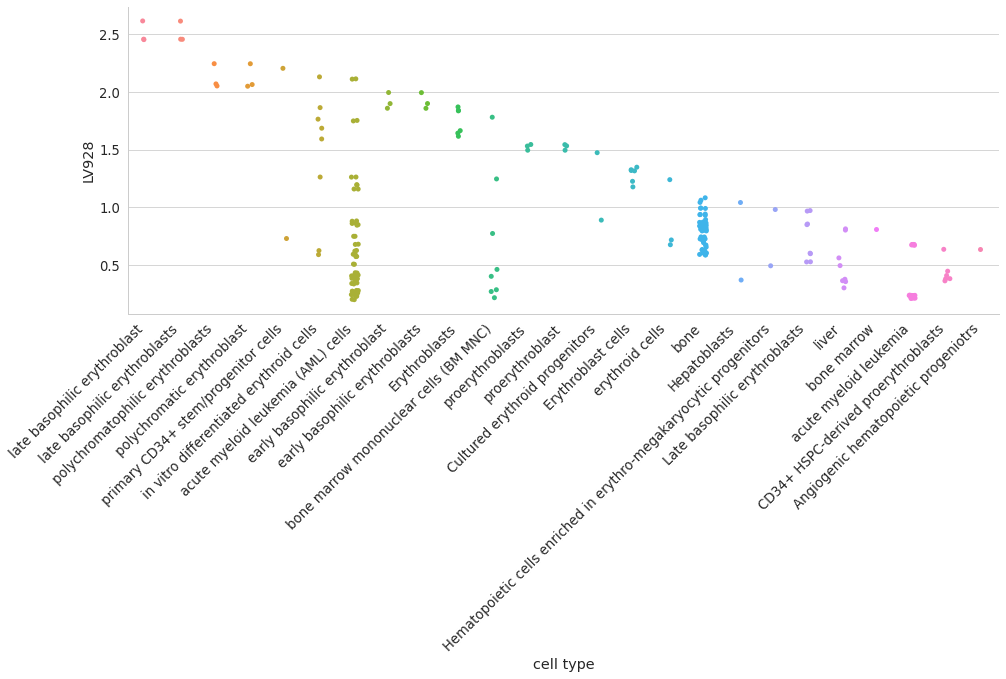

In [41]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [42]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
#     display(_tmp.head(20))

In [43]:
# # what is there in these projects?
# lv_data.loc[["SRP050499"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)